Comptes:

- Nullosdu26

- Quantfish

- AxelM444

- Aubzher

- NW_le_goat

In [50]:
# Import necessary libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from itertools import product

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
import xgboost as xgb

# 1) Data import

In [51]:
# Clinical Data
clinical_df=pd.read_csv('X_train/clinical_train.csv')
clinical_to_pred=pd.read_csv('X_test/clinical_test.csv')

# Molecular Data
mutations_df=pd.read_csv('X_train/molecular_train.csv')
mutations_to_pred=pd.read_csv('X_test/molecular_test.csv')

# Target Train
target_df=pd.read_csv('target_train.csv')

# 2) Clinical Datasets Preprocessing

### 2.1) Training Dataset Analysis

In [52]:
# Preview of the dataset
print('Data size:', clinical_df.shape)
clinical_df.head()

Data size: (3323, 9)


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [53]:
# Categorical columns analysis

categorical_columns=['CENTER','CYTOGENETICS']

for column_name in categorical_columns:
    nb_uniques=clinical_df[column_name].nunique(dropna=True)
    nb_missing=clinical_df[column_name].isna().sum()
    print(f'{column_name}: {nb_uniques} uniques values, {nb_missing} missing values ({round(100*nb_missing/clinical_df.shape[0],1)}%)')

CENTER: 23 uniques values, 0 missing values (0.0%)
CYTOGENETICS: 1194 uniques values, 387 missing values (11.6%)


BM_BLAST: 109 missing values (3.3%), mean: 5.98, standard_deviation: 7.62, min: 0.0, max: 91.0, median: 3.0, skewness: 3.62
WBC: 272 missing values (8.2%), mean: 6.54, standard_deviation: 10.25, min: 0.2, max: 154.4, median: 4.1, skewness: 7.09
ANC: 193 missing values (5.8%), mean: 3.26, standard_deviation: 5.24, min: 0.0, max: 109.62, median: 2.0, skewness: 8.07
MONOCYTES: 601 missing values (18.1%), mean: 0.96, standard_deviation: 2.67, min: 0.0, max: 44.2, median: 0.37, skewness: 8.94
HB: 110 missing values (3.3%), mean: 9.89, standard_deviation: 2.04, min: 4.0, max: 16.6, median: 9.7, skewness: 0.25
PLT: 124 missing values (3.7%), mean: 167.05, standard_deviation: 149.48, min: 2.0, max: 1451.0, median: 123.0, skewness: 2.32


/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

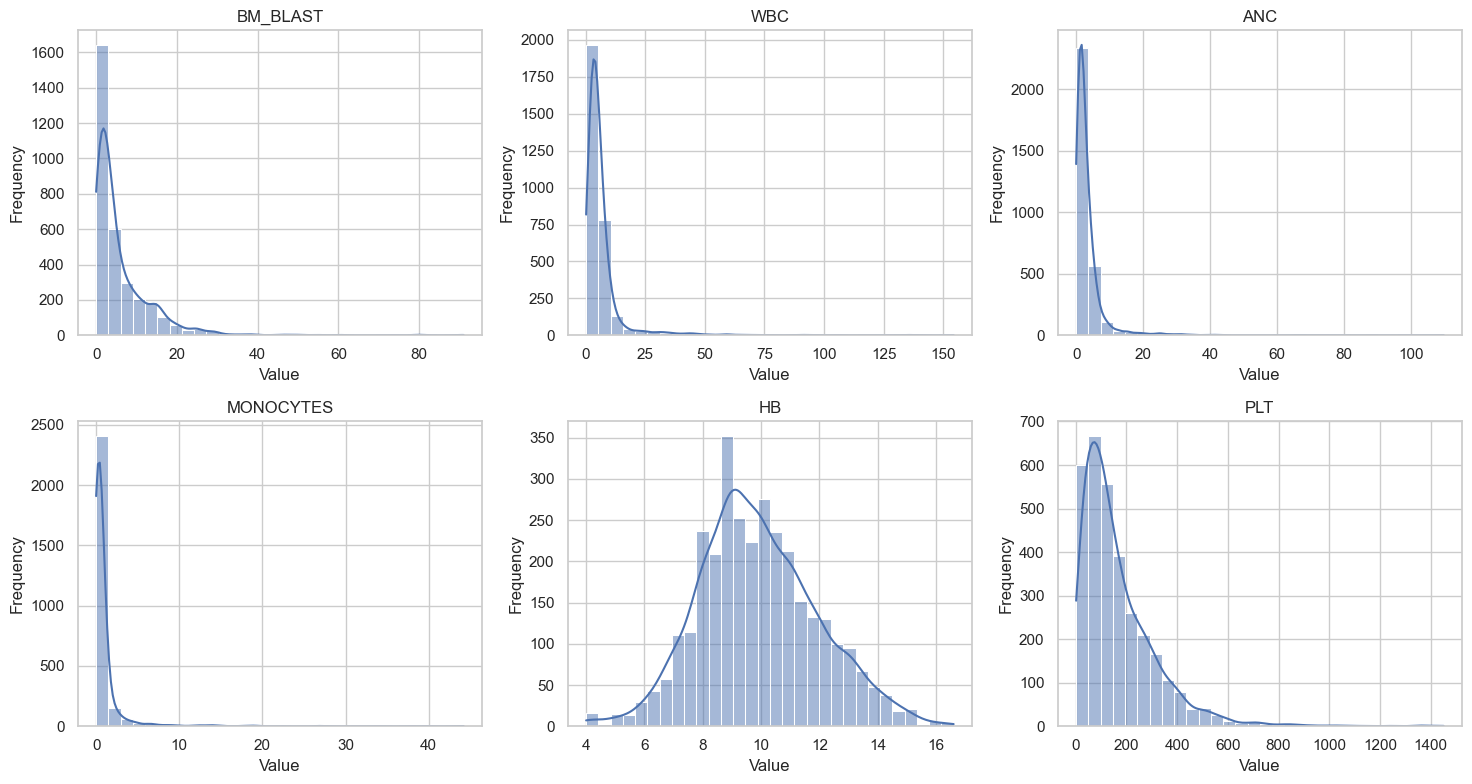

In [54]:
# Numerical columns analysis

numerical_columns=['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']

for column_name in numerical_columns:
    nb_missing=clinical_df[column_name].isna().sum()
    avg=clinical_df[column_name].mean()
    std_dev=clinical_df[column_name].std()
    min_val=clinical_df[column_name].min()
    max_val=clinical_df[column_name].max()
    median=clinical_df[column_name].median()
    skewness=clinical_df[column_name].skew()
    print(f'{column_name}: {nb_missing} missing values ({round(100*nb_missing/clinical_df.shape[0],1)}%),',
          f'mean: {round(avg,2)}, standard_deviation: {round(std_dev,2)},',
          f'min: {round(min_val,2)}, max: {round(max_val,2)}, median: {round(median,2)},',
          f'skewness: {round(skewness,2)}')
    
sns.set(style="whitegrid")

n_cols=3
n_rows=len(numerical_columns)// n_cols

plt.figure(figsize=(15, 8))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=clinical_df, x=column_name, bins=30, kde=True, edgecolor=None)
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [55]:
nb_rows_with_nan=clinical_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {nb_rows_with_nan} ({round(100*nb_rows_with_nan/clinical_df.shape[0])}%)")

nb_rows_with_1_missing=(clinical_df.isna().sum(axis=1)==1).sum()
print(f"{nb_rows_with_1_missing} rows have exactly 1 missing value ({round(100*nb_rows_with_1_missing/clinical_df.shape[0])}%)")

Number of rows with at least one missing value: 776 (23%)
444 rows have exactly 1 missing value (13%)


### 2.2) Interference Set Analysis

In [56]:
# Categorical columns analysis

for column_name in categorical_columns:
    nb_uniques=clinical_to_pred[column_name].nunique(dropna=True)
    nb_missing=clinical_to_pred[column_name].isna().sum()
    print(f'{column_name}: {nb_uniques} uniques values, {nb_missing} missing values ({round(100*nb_missing/clinical_to_pred.shape[0],1)}%)')

CENTER: 1 uniques values, 0 missing values (0.0%)
CYTOGENETICS: 708 uniques values, 116 missing values (9.7%)


BM_BLAST: 115 missing values (9.6%), mean: 12.97, standard_deviation: 17.28, min: 0.0, max: 96.0, median: 6.0, skewness: 2.3
WBC: 112 missing values (9.4%), mean: 7.33, standard_deviation: 20.67, min: 0.0, max: 338.1, median: 2.9, skewness: 9.89
ANC: 141 missing values (11.8%), mean: 2.98, standard_deviation: 6.48, min: 0.0, max: 76.14, median: 1.3, skewness: 6.27
MONOCYTES: 883 missing values (74.0%), mean: 0.83, standard_deviation: 2.49, min: 0.0, max: 25.27, median: 0.2, skewness: 5.81
HB: 111 missing values (9.3%), mean: 8.82, standard_deviation: 2.26, min: 2.7, max: 23.8, median: 8.4, skewness: 0.85
PLT: 115 missing values (9.6%), mean: 120.63, standard_deviation: 162.57, min: 0.0, max: 2150.0, median: 74.0, skewness: 5.34


/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

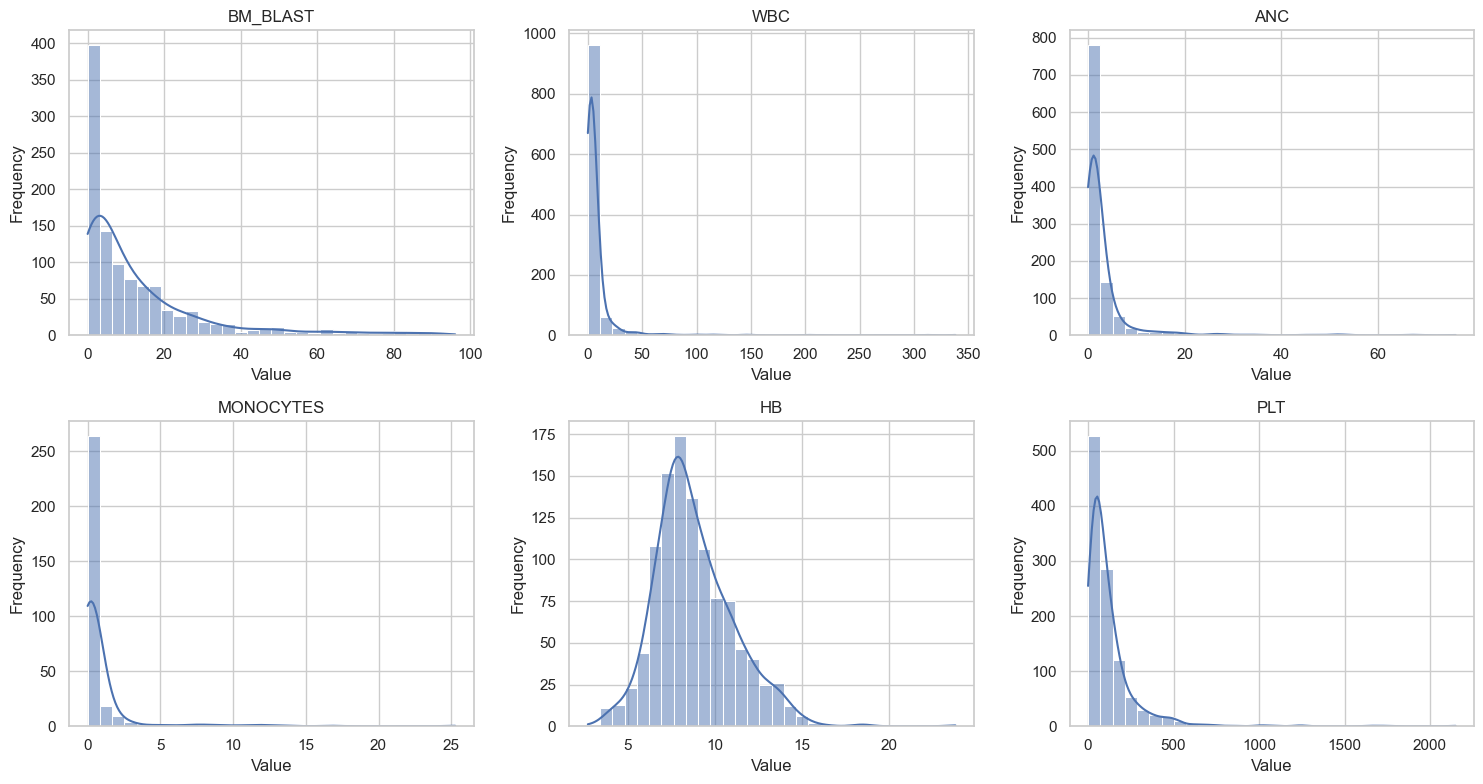

In [57]:
# Numerical columns analysis

for column_name in numerical_columns:
    nb_missing=clinical_to_pred[column_name].isna().sum()
    avg=clinical_to_pred[column_name].mean()
    std_dev=clinical_to_pred[column_name].std()
    min_val=clinical_to_pred[column_name].min()
    max_val=clinical_to_pred[column_name].max()
    median=clinical_to_pred[column_name].median()
    skewness=clinical_to_pred[column_name].skew()
    print(f'{column_name}: {nb_missing} missing values ({round(100*nb_missing/clinical_to_pred.shape[0],1)}%),',
          f'mean: {round(avg,2)}, standard_deviation: {round(std_dev,2)},',
          f'min: {round(min_val,2)}, max: {round(max_val,2)}, median: {round(median,2)},',
          f'skewness: {round(skewness,2)}')
    
sns.set(style="whitegrid")

n_cols=3
n_rows=len(numerical_columns)// n_cols

plt.figure(figsize=(15, 8))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=clinical_to_pred, x=column_name, bins=30, kde=True, edgecolor=None)
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2.3) Data Engineering

In [58]:
# Deleting all the rows where we don't have a prediction in the target set

ids_without_nan=target_df[~target_df.isna().any(axis=1)]['ID'].values
target_df=target_df[target_df['ID'].isin(ids_without_nan)].reset_index(drop=True)
clinical_df=clinical_df[clinical_df['ID'].isin(ids_without_nan)].reset_index(drop=True)


Analysis conclusions and ideas to data engineer :

- The MONOCYTES column has a lot of missing values, a first simple approach would be to delete i

- We need to group some of the labels in the CYTOGENETICS column, as there are currently too many distinct categories

- The graphs show that there might be some outliers in the numerical columns. They are in both datasets so we need to keep them, but we can cap them.

- Most numerical columns are right skewed, so a applying a log transformation may be beneficial to avoid skewness and reduce variance

- A lot of missing values in both datasets. We need to interpolate every single ones.

Limite pour les outliers ? Ex: tout ce qui est au dessus de mediane + IQR en prend la valeur, pour éviter de dévier mean et stdev.

Par exemple, si on a un BMI de 200, on le met a 40; si on a un BMI de 1, on le met a 15 etc...

In [59]:
# Feature engineering of the CYTOGENETICS column

anomalies=["DEL","ADD","DER","T(","INV","+","-"]

def detect_anomalies(karyotype):
    if pd.isna(karyotype):
        return None
    
    karyotype=str(karyotype).upper().replace(" ", "")

    karyotype_desc={
        'Normal':0,
        'Complex':0,
        'Sexual_chromosome_abnormalities':0,
        'Copy_number_abnormalities':0,
        'Structural_abnormalities':0
    }

    # Normal
    if ("46,XX" in karyotype or "46,XY" in karyotype) and not any(a in karyotype for a in ["DEL","ADD","DER","T(","INV","+","-"]):
        karyotype_desc["Normal"]=1

    # Complex
    if karyotype.count(',') >= 5 or any(op in karyotype for op in ['+2MAR', '+3MAR', '+4MAR']):
        karyotype_desc["Complex"]=1

    # If we don't have information other than complex on the caryotype, we suppose that there is one abnormality per category
    if 'COMPLEX' in karyotype or '>3ABNORMALITIES' in karyotype:
        karyotype_desc["Complex"]=1
        karyotype_desc['Sexual_chromosome_abnormalities']=1
        karyotype_desc['Copy_number_abnormalities']=1
        karyotype_desc['Structural_abnormalities']=1

    # Specific sexual chromosomes
    if '47,XXY' in karyotype or '45,X' in karyotype or 'XXX' in karyotype or 'X,X,Y' in karyotype:
        karyotype_desc['Sexual_chromosome_abnormalities']=1

    # Number of anomalies copy
    copy_number_patterns = [r'\+\d+',r'\+[XY]',r'-\d+',r'-[XY]','TRIS', 'PLUS','MINUS']
    karyotype_desc['Copy_number_abnormalities']=sum(len(re.findall(pattern, karyotype)) for pattern in copy_number_patterns)

    # Number of structural anomalies
    karyotype_desc['Structural_abnormalities']=sum(1 for a in ["DEL","ADD","T(","INV","I(","MAR"] if a in karyotype)

    return None if all(value==0 for value in karyotype_desc.values()) else karyotype_desc 

def replace_cytogenetics(df):
    karyotype_keys=['Normal','Complex','Sexual_chromosome_abnormalities','Copy_number_abnormalities','Structural_abnormalities']
    def extract_karyotype_features(karyotype):
        res=detect_anomalies(karyotype)
        if res is None:
            return pd.Series([np.nan] * len(karyotype_keys), index=karyotype_keys)
        else:
            return pd.Series([res[key] for key in karyotype_keys], index=karyotype_keys)
    karyo_df = df['CYTOGENETICS'].apply(extract_karyotype_features)
    df = pd.concat([df.drop(columns=['CYTOGENETICS']), karyo_df], axis=1)
    return df

clinical_df=replace_cytogenetics(clinical_df)
clinical_to_pred=replace_cytogenetics(clinical_to_pred)
clinical_df.head()


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,Normal,Complex,Sexual_chromosome_abnormalities,Copy_number_abnormalities,Structural_abnormalities
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,0.0,0.0,0.0,0.0,1.0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,1.0,0.0,0.0,0.0,0.0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,0.0,0.0,0.0,0.0,1.0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,0.0,0.0,0.0,0.0,1.0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,0.0,0.0,0.0,0.0,1.0


In [60]:
# Delete CENTER (only one center in the interference set) and MONOCYTES (too many missing values)
clinical_df=clinical_df.drop(columns=['CENTER','MONOCYTES'])  
clinical_to_pred=clinical_to_pred.drop(columns=['CENTER','MONOCYTES'])  

In [61]:
### Handling numerical columns

numerical_cols=['BM_BLAST', 'WBC', 'ANC', 'HB', 'PLT']  # we delete MONOCYTES 
skewed_cols=['BM_BLAST', 'WBC', 'ANC', 'PLT']  # HB is not skewed

# Imputation of missing values with iterative imputer for numerical features
iter_imputer = IterativeImputer(random_state=42)
clinical_df[numerical_cols]=iter_imputer.fit_transform(clinical_df[numerical_cols])
clinical_to_pred[numerical_cols]=iter_imputer.transform(clinical_to_pred[numerical_cols])

# Adding new features
epsilon=1e-3

clinical_df['WBC_to_PLT']=clinical_df['WBC']/(clinical_df['PLT']+epsilon)
clinical_df['ANC_to_WBC']=clinical_df['ANC']/(clinical_df['WBC']+epsilon)

clinical_to_pred['WBC_to_PLT']=clinical_to_pred['WBC']/(clinical_to_pred['PLT']+epsilon)
clinical_to_pred['ANC_to_WBC']=clinical_to_pred['ANC']/(clinical_to_pred['WBC']+epsilon)

numerical_cols=numerical_cols+['WBC_to_PLT','ANC_to_WBC']  # adding new columns
skewed_cols=skewed_cols+['WBC_to_PLT']  # ANC_to_WBC is not skewed

# Adding a bound to the column
for col in numerical_cols:
    Q1=clinical_df[col].quantile(0.25)
    Q3=clinical_df[col].quantile(0.75)
    IQR=Q3-Q1
    upper_bound=Q3+1.5*IQR
    lower_bound=Q1-1.5*IQR
    clinical_df[col]=np.clip(clinical_df[col], lower_bound, upper_bound)
    clinical_to_pred[col]=np.clip(clinical_to_pred[col], lower_bound, upper_bound)

# Log transformation of skewed columns
for col in skewed_cols:
    clinical_df[col]=clinical_df[col].apply(lambda x: x if x > 0 else 1e-3)
    clinical_to_pred[col]=clinical_to_pred[col].apply(lambda x: x if x > 0 else 1e-3)
    clinical_df[col]=np.log1p(clinical_df[col])
    clinical_to_pred[col]=np.log1p(clinical_to_pred[col])

# Standardisation
scaler=StandardScaler()
clinical_df[numerical_cols]=scaler.fit_transform(clinical_df[numerical_cols])
clinical_to_pred[numerical_cols]=scaler.transform(clinical_to_pred[numerical_cols])

In [62]:
### Handling categorical variables

categorical_cols=['Normal','Complex','Sexual_chromosome_abnormalities','Copy_number_abnormalities','Structural_abnormalities']

# Interpolation of missing data
knn_imputer = KNNImputer(n_neighbors=5)
clinical_df[categorical_cols]=knn_imputer.fit_transform(clinical_df[categorical_cols])
clinical_to_pred[categorical_cols]=knn_imputer.transform(clinical_to_pred[categorical_cols])

# Transformation to binary
clinical_df[categorical_cols]=(clinical_df[categorical_cols]>=0.5).astype(int)
clinical_to_pred[categorical_cols]=(clinical_to_pred[categorical_cols]>=0.5).astype(int)

In [63]:
clinical_df.head()

,ID,BM_BLAST,WBC,ANC,HB,PLT,Normal,Complex,Sexual_chromosome_abnormalities,Copy_number_abnormalities,Structural_abnormalities,WBC_to_PLT,ANC_to_WBC
0,P132697,1.381298,-0.702476,-1.743910,-1.141941,0.052691,0,0,0,0,1,-0.617801,-2.232668
1,P132698,-0.981757,0.882163,0.139703,0.879763,-1.069214,1,0,0,0,0,2.049171,-0.847006
2,P116889,1.456988,-0.277841,-0.027367,2.193870,-0.363556,0,0,0,0,1,-0.080430,0.485266
3,P132699,-0.981757,-0.194591,-0.147988,-0.484887,-0.418226,0,0,0,0,1,0.038590,0.044928
4,P132700,0.487469,1.802424,1.818094,0.627050,0.589022,0,0,0,0,1,2.049171,-2.208681


# 3) Molecular Dataset Preprocessing

### 3.1) Training Dataset Analysis

In [64]:
# Preview of the dataset
print('Data size:', mutations_df.shape)
mutations_df.head()

Data size: (10935, 11)


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


In [65]:
# Categorical columns analysis
categorical_columns=['CHR','REF','ALT','GENE','PROTEIN_CHANGE','EFFECT']

for column_name in categorical_columns:
    nb_uniques=mutations_df[column_name].nunique(dropna=True)
    nb_missing=mutations_df[column_name].isna().sum()
    print(f'{column_name}: {nb_uniques} uniques values, {nb_missing} missing values ({round(100*nb_missing/mutations_df.shape[0],1)}%)')

CHR: 23 uniques values, 114 missing values (1.0%)
REF: 406 uniques values, 114 missing values (1.0%)
ALT: 332 uniques values, 114 missing values (1.0%)
GENE: 124 uniques values, 0 missing values (0.0%)
PROTEIN_CHANGE: 4686 uniques values, 12 missing values (0.1%)
EFFECT: 16 uniques values, 0 missing values (0.0%)


In [66]:
effect_counts=mutations_df['EFFECT'].value_counts(dropna=False)
print(effect_counts)


EFFECT
non_synonymous_codon            5471
frameshift_variant              2877
stop_gained                     1673
splice_site_variant              512
inframe_codon_loss               168
PTD                               89
inframe_codon_gain                55
ITD                               26
initiator_codon_change            24
2KB_upstream_variant              12
complex_change_in_transcript      11
3_prime_UTR_variant                5
stop_lost                          4
inframe_variant                    4
synonymous_codon                   3
stop_retained_variant              1
Name: count, dtype: int64


VAF: 89 missing values (0.8%), mean: 0.31, standard_deviation: 0.21, min: 0.02, max: 1.0, median: 0.32, skewness: 0.66
DEPTH: 114 missing values (1.0%), mean: 1051.23, standard_deviation: 552.86, min: 16.0, max: 7156.0, median: 975.0, skewness: 1.25


/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/axelm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


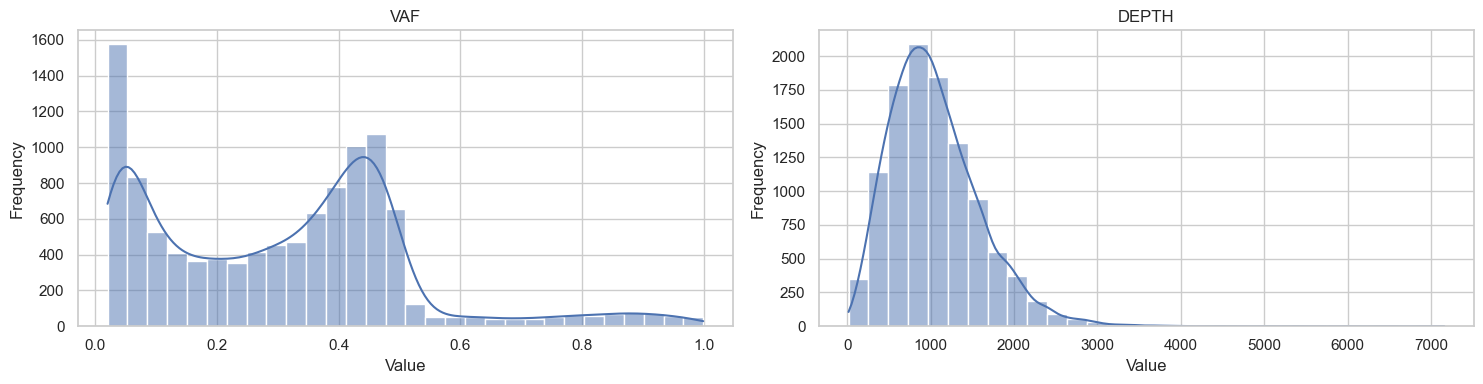

In [67]:
# Numerical columns analysis

numerical_columns=['VAF', 'DEPTH']

for column_name in numerical_columns:
    nb_missing=mutations_df[column_name].isna().sum()
    avg=mutations_df[column_name].mean()
    std_dev=mutations_df[column_name].std()
    min_val=mutations_df[column_name].min()
    max_val=mutations_df[column_name].max()
    median=mutations_df[column_name].median()
    skewness=mutations_df[column_name].skew()
    print(f'{column_name}: {nb_missing} missing values ({round(100*nb_missing/mutations_df.shape[0],1)}%),',
          f'mean: {round(avg,2)}, standard_deviation: {round(std_dev,2)},',
          f'min: {round(min_val,2)}, max: {round(max_val,2)}, median: {round(median,2)},',
          f'skewness: {round(skewness,2)}')
    
sns.set(style="whitegrid")

n_cols=2
n_rows=len(numerical_columns)// n_cols

plt.figure(figsize=(15, 4))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=mutations_df, x=column_name, bins=30, kde=True, edgecolor=None)
    plt.title(column_name)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3.3) Data Engineering

List of useful features to create :

- Total Number of Mutations

- Average VAF per patient

- Max VAF per patient

- Average DEPTH per patient

- Number of mutated genes per patient

In [68]:
# Splitting the different effects in binary columns
def has_damaging_effect(effect):
    return int(effect in ['frameshift_variant', 'stop_gained', 'stop_lost','splice_site_variant', 'initiator_codon_change','inframe_codon_loss'])

def has_moderate_effect(effect):
    return int(effect in ['non_synonymous_codon', 'inframe_codon_gain','inframe_variant'])

mutations_df['has_damaging_effect']=mutations_df['EFFECT'].apply(has_damaging_effect)
mutations_df['has_moderate_effect']=mutations_df['EFFECT'].apply(has_moderate_effect)
mutations_to_pred['has_damaging_effect']=mutations_to_pred['EFFECT'].apply(has_damaging_effect)
mutations_to_pred['has_moderate_effect']=mutations_to_pred['EFFECT'].apply(has_moderate_effect)

# Agrefation of the new features
mutations_features_df=pd.concat([
    mutations_df.groupby('ID').size().rename('total_mutations'),
    mutations_df.groupby('ID')['VAF'].mean().rename('avg_VAF'),
    mutations_df.groupby('ID')['VAF'].max().rename('max_VAF'),
    mutations_df.groupby('ID')['DEPTH'].mean().rename('avg_DEPTH'),
    mutations_df.groupby('ID')['GENE'].nunique().rename('num_mutated_genes'),
    mutations_df.groupby('ID')['has_damaging_effect'].sum().rename('n_damaging_effects'),
    mutations_df.groupby('ID')['has_moderate_effect'].sum().rename('n_moderate_effects')
], axis=1).reset_index()

mutations_features_pred=pd.concat([
    mutations_to_pred.groupby('ID').size().rename('total_mutations'),
    mutations_to_pred.groupby('ID')['VAF'].mean().rename('avg_VAF'),
    mutations_to_pred.groupby('ID')['VAF'].max().rename('max_VAF'),
    mutations_to_pred.groupby('ID')['DEPTH'].mean().rename('avg_DEPTH'),
    mutations_to_pred.groupby('ID')['GENE'].nunique().rename('num_mutated_genes'),
    mutations_to_pred.groupby('ID')['has_damaging_effect'].sum().rename('n_damaging_effects'),
    mutations_to_pred.groupby('ID')['has_moderate_effect'].sum().rename('n_moderate_effects')
], axis=1).reset_index()

# Harmonisation of the columns
all_cols = set(mutations_features_df.columns).union(set(mutations_features_pred.columns))
for col in all_cols:
    if col not in mutations_features_df.columns:
        mutations_features_df[col]=0
    if col not in mutations_features_pred.columns:
        mutations_features_pred[col]=0

mutations_features_df=mutations_features_df.reindex(columns=sorted(all_cols))
mutations_features_pred=mutations_features_pred.reindex(columns=sorted(all_cols))

# Fusion of the mutation features with the clinical dataset
clinical_df=clinical_df.merge(mutations_features_df, on='ID', how='left')
clinical_to_pred=clinical_to_pred.merge(mutations_features_pred, on='ID', how='left')

# Replacing NaN by zeroes
mutation_feature_cols=mutations_features_df.columns.difference(['ID'])
clinical_df[mutation_feature_cols]=clinical_df[mutation_feature_cols].fillna(0)
clinical_to_pred[mutation_feature_cols]=clinical_to_pred[mutation_feature_cols].fillna(0)

# Standardisation of continuous columns and normalization of other columns
cols_to_standardize=['avg_VAF', 'max_VAF', 'avg_DEPTH']
scaler=StandardScaler()
clinical_df[cols_to_standardize]=scaler.fit_transform(clinical_df[cols_to_standardize])
clinical_to_pred[cols_to_standardize]=scaler.transform(clinical_to_pred[cols_to_standardize])

cols_to_normalize=['Sexual_chromosome_abnormalities','Copy_number_abnormalities','Structural_abnormalities','n_damaging_effects','n_moderate_effects','num_mutated_genes','total_mutations']
scaler=MinMaxScaler()
clinical_df[cols_to_normalize]=scaler.fit_transform(clinical_df[cols_to_normalize])
clinical_to_pred[cols_to_normalize]=scaler.transform(clinical_to_pred[cols_to_normalize])

# 4) Models training and predictions

### 4.1) Baseline: CoxPH

In [69]:
X=clinical_df.drop(columns=['ID'])
y=Surv.from_dataframe('OS_STATUS','OS_YEARS',target_df)

cox=CoxPHSurvivalAnalysis()
cox.fit(X, y)

xgb_risk_scores=cox.predict(X)
c_index, *_=concordance_index_censored(target_df['OS_STATUS'].astype(bool), target_df['OS_YEARS'], xgb_risk_scores)
print("Concordance Index (C-index):", c_index)

interference_ID=clinical_to_pred['ID']
X_interference=clinical_to_pred.drop(columns=['ID'])
baseline_pred=cox.predict(X_interference)
baseline_submission=pd.DataFrame({'ID': interference_ID,'risk_score': baseline_pred})
baseline_submission.to_csv('baseline_pred.csv',index=False)

Concordance Index (C-index): 0.7364361913969946


### 4.2) XGBoost

In [70]:
### Tuning of the model
X=clinical_df.drop(columns=['ID'])
y_lower_bound=target_df['OS_YEARS']
y_upper_bound=np.where(target_df['OS_STATUS']==0,np.inf,target_df['OS_YEARS'].values)
event=target_df['OS_STATUS'].astype(bool).values
time=target_df['OS_YEARS'].values

kf=KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters grid
learning_rates=[0.01,0.05,0.1]
max_depths=[2,3,4]
scales=[0.8,1,1.2]
num_boost_rounds_list=[100,125,150,175,200]
distributions=['normal','logistic']

best_score,best_params=-np.inf,None

# Loop to determine the best parameters
for lr, depth, scale, n_boost,distribution in product(learning_rates, max_depths, scales, num_boost_rounds_list,distributions):
    c_index_scores=[]
    for train_idx,val_idx in kf.split(X):
        X_train,X_val=X.iloc[train_idx],X.iloc[val_idx]
        y_lower_train,y_upper_train=y_lower_bound[train_idx],y_upper_bound[train_idx]
        X_val_reset=X_val.reset_index(drop=True)
        dtrain=xgb.DMatrix(X_train)
        dtrain.set_float_info('label_lower_bound', y_lower_train)
        dtrain.set_float_info('label_upper_bound', y_upper_train)
        dval = xgb.DMatrix(X_val_reset)
        params = {
            'objective': 'survival:aft',
            'eval_metric': 'aft-nloglik',
            'aft_loss_distribution': distribution,
            'aft_loss_distribution_scale': scale,
            'tree_method': 'hist',
            'learning_rate': lr,
            'max_depth': depth,
            'verbosity': 0
        }

        bst=xgb.train(params, dtrain, num_boost_round=n_boost, verbose_eval=False)
        preds=-bst.predict(dval)
        c_index, *_=concordance_index_censored(event[val_idx], time[val_idx], preds)
        c_index_scores.append(c_index)

    mean_c_index=np.mean(c_index_scores)

    if mean_c_index>best_score:
        best_score=mean_c_index
        best_params={'learning_rate': lr, 'max_depth': depth, 'aft_loss_distribution_scale': scale, 'num_boost_round': n_boost, 'distribution': distribution}

print("\nBest params:", best_params)
print("Best Cross-validated C-index: {:.4f}".format(best_score))



Best params: {'learning_rate': 0.05, 'max_depth': 2, 'aft_loss_distribution_scale': 1, 'num_boost_round': 150, 'distribution': 'logistic'}
Best Cross-validated C-index: 0.7351


In [71]:
### Model training
dX=xgb.DMatrix(X)
dX.set_float_info('label_lower_bound', y_lower_bound)
dX.set_float_info('label_upper_bound', y_upper_bound)

params={'objective': 'survival:aft','eval_metric': 'aft-nloglik','aft_loss_distribution': 'logistic','aft_loss_distribution_scale': 1,'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 2}
bst=xgb.train(params, dX, num_boost_round=150,evals=[(dX, 'train')],verbose_eval=False)

xgb_risk_scores=-bst.predict(dX)
c_index, *_=concordance_index_censored(target_df['OS_STATUS'].astype(bool), target_df['OS_YEARS'], xgb_risk_scores)
print("Concordance Index (C-index):", c_index)

interference_ID=clinical_to_pred['ID']
X_interference=clinical_to_pred.drop(columns=['ID'])
dX_interference=xgb.DMatrix(X_interference)
xgb_pred=-bst.predict(dX_interference)

xgb_submission=pd.DataFrame({'ID': interference_ID,'risk_score': xgb_pred})
xgb_submission.to_csv('xgb_submission.csv',index=False)

Concordance Index (C-index): 0.7613480320093733
